# Calibration of the 9-Mythen detector at the Cristal beamline at Soleil

Mythen detectors are 1D-strip detector sold by Dectris. 
On the Cristal beamline at Soleil, 9 of them are mounted on the goniometer. 

This notebook explains how to calibrate precisely their position (including the wavelength used) as function of the goniometer position.

All input data are provided in a Nexus file wich contrains both the (approximate) energy, the goniometer positions (500 points have been measured) and the measured signal.

As pyFAI is not made for 1D data, the Mythen detector will be considered as a 1x1280 image.

We start by importing a whole bunch of modules:

In [1]:
%matplotlib inline
# use `widget` for better user experience; `inline` is for documentation generation

In [2]:
from collections import OrderedDict
from matplotlib import pyplot as plt
import numpy
import os
import h5py
from silx.resources import ExternalResources

from pyFAI import goniometer
from pyFAI.detectors import Detector
from pyFAI.goniometer import ExtendedTransformation, GoniometerRefinement
from pyFAI.control_points import ControlPoints
from pyFAI.geometryRefinement import GeometryRefinement
from pyFAI.gui import jupyter
from pyFAI.units import hc
from pyFAI.calibrant import get_calibrant
from pyFAI.containers import Integrate1dResult

import ipywidgets as widgets

from scipy.signal import find_peaks_cwt
from scipy.interpolate import interp1d
from scipy.optimize import bisect, minimize
from scipy.spatial import distance_matrix
import time

start_time = time.time()

/home/jerome/.venv/py311/lib/python3.11/site-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/home/jerome/.venv/py311/lib/python3.11/site-packages/pyopencl/cache.py:499: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  prg.build(options_bytes, devices)


In [3]:
#Nota: Useful to configure a proxy if you are behind a firewall
#os.environ["http_proxy"] = "http://proxy.company.fr:3128"

downloader = ExternalResources("detector_calibration", "http://www.silx.org/pub/pyFAI/gonio/")
mythen_ring_file = downloader.getfile("LaB6_17keV_att3_tth2C_24_01_2018_19-43-20_1555.nxs")


The data file can be downoaded from:
http://www.silx.org/pub/pyFAI/gonio/LaB6_17keV_att3_tth2C_24_01_2018_19-43-20_1555.nxs

In [4]:
#Open the Nexus file and retrieve the actual positions:

h5 = h5py.File(mythen_ring_file, mode="r")
position = h5["/LaB6_17keV_att3_1555/scan_data/actuator_1_1"][:]
print("Positions: ", position[:5], "...")

Positions:  [90.00000001 89.79994445 89.5998889  89.39994445 89.19994445] ...


In [5]:
#Read all data

data = {}
ds_names = []
for idx in range(1,13):
    name = "data_%02i"%idx
    ds = h5["/LaB6_17keV_att3_1555/scan_data/"+name][:]
    print(name, ds.shape)
    if ds.shape[1]<2000:
        #Keep only the single modules
        data[name] = ds
        ds_names.append(name)

print(ds_names)


data_01 (501, 5120)
data_02 (501, 1280)
data_03 (501, 1280)
data_04 (501, 1280)
data_05 (501, 1280)
data_06 (501, 5120)
data_07 (501, 1280)
data_08 (501, 1280)
data_09 (501, 1280)
data_10 (501, 1280)
data_11 (501, 1280)
data_12 (501, 1280)
['data_02', 'data_03', 'data_04', 'data_05', 'data_07', 'data_08', 'data_09', 'data_10', 'data_11', 'data_12']


In [6]:
#Define a Mythen-detector mounted vertically:

class MythenV(Detector):
    "Verical Mythen dtrip detector from Dectris"
    aliases = ["MythenV 1280"]
    force_pixel = True
    MAX_SHAPE = (1280, 1)

    def __init__(self,pixel1=50e-6, pixel2=8e-3):
        super(MythenV, self).__init__(pixel1=pixel1, pixel2=pixel2)



In [7]:
#Define all modules as single detectors of class MythenV. 
# Each one has a mask defined from dummy-values in the dataset

modules = {}
for name, ds in data.items():
    one_module = MythenV()
    mask = ds[0]<0
    #discard the first 20 and last 20 pixels as their intensities are less reliable
    mask[:20] = True
    mask[-20:] = True
    one_module.mask = mask.reshape(-1,1)
    modules[name] = one_module

for k,v in modules.items():
    print(k, v.name)

data_02 MythenV 1280
data_03 MythenV 1280
data_04 MythenV 1280
data_05 MythenV 1280
data_07 MythenV 1280
data_08 MythenV 1280
data_09 MythenV 1280
data_10 MythenV 1280
data_11 MythenV 1280
data_12 MythenV 1280


In [8]:
# Define a peak-picking function based on the dataset-name and the frame_id:

def peak_picking(module_name, frame_id,  
                 threshold=500):
    """Peak-picking base on find_peaks_cwt from scipy plus 
    second-order tailor exapention refinement for sub-pixel resolution.
    
    The half-pixel offset is accounted here, i.e pixel #0 has its center at 0.5
    
    """
    module = modules[module_name]
    msk = module.mask.ravel()
    
    spectrum = data[module_name][frame_id]
    guess = find_peaks_cwt(spectrum, [20])
    
    valid = numpy.logical_and(numpy.logical_not(msk[guess]), 
                               spectrum[guess]>threshold)
    guess = guess[valid]
    
    #Based on maximum is f'(x) = 0 ~ f'(x0) + (x-x0)*(f''(x0))
    df = numpy.gradient(spectrum)
    d2f = numpy.gradient(df)
    bad = d2f==0
    d2f[bad] = 1e-10 #prevent devision by zero. Discared later on
    cor = df / d2f
    cor[abs(cor)>1] = 0
    cor[bad] = 0
    ref = guess - cor[guess] + 0.5 #half a pixel offset
    x = numpy.zeros_like(ref) + 0.5 #half a pixel offset
    return numpy.vstack((ref,x)).T

%timeit peak_picking(ds_names[0], 93)
print(peak_picking(ds_names[0], 93))

13 ms ± 69.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
[[287.06072343   0.5       ]]


In [9]:
nrj = h5["/LaB6_17keV_att3_1555/CRISTAL/Monochromator/energy"][0]
wl = hc / nrj *1e-10
print("Energy (keV): ",nrj, "\nWavelength (A): ",wl)

LaB6 = get_calibrant("LaB6")
LaB6.wavelength = wl
print(LaB6)

Energy (keV):  17.027082549190933 
Wavelength (A):  7.281587910025816e-11
LaB6 Calibrant with 109 reflections at wavelength 7.281587910025816e-11


In [10]:
#This cell defines the transformation of coordinates for a simple goniometer mounted vertically.

trans = ExtendedTransformation(dist_expr="dist", 
                                   poni1_expr="poni1", 
                                   poni2_expr="poni2", 
                                   rot1_expr="rot1", 
                                   rot2_expr="pi*(offset+scale*angle)/180.", 
                                   rot3_expr="0.0", 
                                   wavelength_expr="hc/nrj*1e-10", 
                                   param_names=["dist", "poni1", "poni2", "rot1", "offset", "scale", "nrj"], 
                                   pos_names=["angle"], 
                                   constants={"hc": hc})

In [11]:
def get_position(idx):
    "Returns the postion of the goniometer for the given frame_id"
    return position[idx]

#Approximate offset for the module #0 at 0°
print("Approximated offset for the first module: ",get_position(36))

Approximated offset for the first module:  82.79994445106844


/tmp/ipykernel_367778/505442400.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


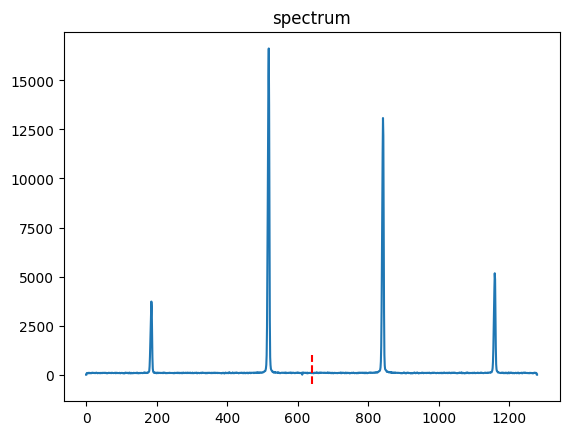

interactive(children=(IntSlider(value=4, description='module_id', max=9), IntSlider(value=250, description='fr…

In [12]:
#This interactive plot lets one visualize any spectra acquired by any module

fig, ax = plt.subplots()
line = ax.plot(data[ds_names[0]][250])[0]
ligne = plt.Line2D(xdata=[640,640], ydata=[-500, 1000], figure=fig, linestyle="--", color='red', axes=ax)
ax.add_line(ligne)
ax.set_title("spectrum")
fig.show()

def update(module_id, frame_id):
   spectrum = data[ds_names[module_id]][frame_id]
   line.set_data(numpy.arange(spectrum.size), spectrum)
   ax.set_title("Module %i, Frame %i"%(module_id, frame_id))
   
   fig.canvas.draw()

    
interactive_plot = widgets.interactive(update, 
                                       module_id=(0, len(data)-1), 
                                       frame_id=(0, data[ds_names[0]].shape[0]-1))
display(interactive_plot)

In [13]:
#Work with the first module corresponding to:
name = ds_names[0]
print(name)
ds = data[name]
module = modules[name]

#Use the previous widget to select:
## the index where the beam-center is in the middle of the module
zero_pos = 36

## The frame index where the first LaB6 peak enters the right-hand side of the spectrum
peak_zero_start = 74

## The frame index where this first LaB6 leaves the spectrum or the second LaB6 peak appears:
peak_zero_end = 94

# The frames between peak_zero_start and peak_zero_end will be used to calibrate roughly the goniometer 
# and used later for finer peak extraction

data_02


In [14]:
param0 = {"dist": 0.72, 
          "poni1": 640*50e-6, 
          "poni2": 4e-3, 
          "rot1":0, 
          "offset": -get_position(zero_pos), 
          "scale":1, 
          "nrj": nrj}

#Lock enegy for now and a couple of other parameters
bounds0 = {"nrj": (nrj, nrj),
           "dist": (0.71, 0.73),
           "poni2": (4e-3, 4e-3),
           "rot1": (0,0),
           "scale":(1,1), 
          }

gonioref0 = GoniometerRefinement(param0, 
                                 get_position, 
                                 trans, 
                                 detector=module, 
                                 wavelength=wl, 
                                 bounds=bounds0
                                 )
goniometers = {name:  gonioref0} 
print(gonioref0)

GoniometerRefinement with 0 geometries labeled: .


In [15]:
# Extract the frames where only the peak zero from LaB6 is present.

for i in range(peak_zero_start, peak_zero_end):
    cp = ControlPoints(calibrant=LaB6, wavelength=wl)
    peak = peak_picking(name, i)
    if len(peak)!=1: 
        continue
    cp.append([peak[0]], ring=0)
    img = ds[i].reshape((-1,1)) #Images are vertical ... transpose the spectrum
    sg = gonioref0.new_geometry("%s_%04i"%(name,i), 
                                image=img, 
                                metadata=i, 
                                control_points=cp, 
                                calibrant=LaB6)
    sg.geometry_refinement.data = numpy.array(cp.getList())

print(gonioref0)
print("Residual error before fit:")
print(gonioref0.chi2())

GoniometerRefinement with 20 geometries labeled: data_02_0074, data_02_0075, data_02_0076, data_02_0077, data_02_0078, data_02_0079, data_02_0080, data_02_0081, data_02_0082, data_02_0083, data_02_0084, data_02_0085, data_02_0086, data_02_0087, data_02_0088, data_02_0089, data_02_0090, data_02_0091, data_02_0092, data_02_0093.
Residual error before fit:
6.737408475887519e-07


In [16]:
#First refinement:
gonioref0.refine2()

Cost function before refinement: 6.737408475887519e-07
[ 7.20000000e-01  3.20000000e-02  4.00000000e-03  0.00000000e+00
 -8.27999445e+01  1.00000000e+00  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.490988846910722e-11
       x: [ 7.200e-01  3.141e-02  4.000e-03  0.000e+00 -8.280e+01
            1.000e+00  1.703e+01]
     nit: 2
     jac: [ 1.584e-07  2.919e-08        nan        nan  3.427e-11
                  nan        nan]
    nfev: 9
    njev: 2
Cost function after refinement: 2.490988846910722e-11
GonioParam(dist=0.719994724358983, poni1=0.031408577292064206, poni2=0.004, rot1=0.0, offset=-82.79995188659902, scale=1.0, nrj=17.027082549190933)
maxdelta on: poni1 (1) 0.032 --> 0.031408577292064206


array([ 7.19994724e-01,  3.14085773e-02,  4.00000000e-03,  0.00000000e+00,
       -8.27999519e+01,  1.00000000e+00,  1.70270825e+01])

In [17]:
#Here we extract all spectra for peaks,
# If there are as many peaks as expected from the theoritical LaB6. perform the assignment.

#Peaks from LaB6:
tths = LaB6.get_2th()

for i in range(peak_zero_end, ds.shape[0]):
    peak = peak_picking(name, i)
    ai=gonioref0.get_ai(get_position(i))
    tth = ai.array_from_unit(unit="2th_rad", scale=False)
    tth_low = tth[20]
    tth_hi = tth[-20]
    ttmin, ttmax = min(tth_low, tth_hi), max(tth_low, tth_hi)
    valid_peaks = numpy.logical_and(ttmin<=tths, tths<ttmax)
    cnt = valid_peaks.sum()
    if (len(peak) ==  cnt):    
        cp = ControlPoints(calibrant=LaB6, wavelength=wl)
        #revert the order of assignment if needed !!
        if tth_hi < tth_low:
            peak = peak[-1::-1]
        for p, r in zip(peak, numpy.where(valid_peaks)[0]):
            #print(p,r)
            cp.append([p], ring=r)
        img = ds[i].reshape((-1,1))
        sg = gonioref0.new_geometry("%s_%04i"%(name,i), 
                                    image=img, 
                                    metadata=i, 
                                    control_points=cp, 
                                    calibrant=LaB6)
        sg.geometry_refinement.data = numpy.array(cp.getList())
        #print(sg.label, len(sg.geometry_refinement.data))

#print(gonioref0)
print(" Number of peaks found and used for refinement")
print(sum([len(sg.geometry_refinement.data) for sg in gonioref0.single_geometries.values()]))
print("Residual error before fitting: ", gonioref0.chi2())

 Number of peaks found and used for refinement
1203
Residual error before fitting:  3.118662178645907e-06


In [18]:
gonioref0.refine2()

Cost function before refinement: 3.118662178645907e-06
[ 7.19994724e-01  3.14085773e-02  4.00000000e-03  0.00000000e+00
 -8.27999519e+01  1.00000000e+00  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.7342490266357463e-06
       x: [ 7.231e-01  3.185e-02  4.000e-03  0.000e+00 -8.280e+01
            1.000e+00  1.703e+01]
     nit: 7
     jac: [-5.582e-08 -3.618e-10        nan        nan  6.365e-10
                  nan        nan]
    nfev: 30
    njev: 7
Cost function after refinement: 2.7342490266357463e-06
GonioParam(dist=0.7230953421817191, poni1=0.03184537030470006, poni2=0.004, rot1=0.0, offset=-82.7999466162549, scale=1.0, nrj=17.027082549190933)
maxdelta on: dist (0) 0.719994724358983 --> 0.7230953421817191


array([ 7.23095342e-01,  3.18453703e-02,  4.00000000e-03,  0.00000000e+00,
       -8.27999466e+01,  1.00000000e+00,  1.70270825e+01])

In [19]:
gonioref0.set_bounds("poni1", -1, 1)
gonioref0.set_bounds("poni2", -1, 1)
gonioref0.set_bounds("rot1", -1, 1)
gonioref0.set_bounds("scale", 0.9, 1.1)
gonioref0.refine2()

Cost function before refinement: 2.7342490266357463e-06
[ 7.23095342e-01  3.18453703e-02  4.00000000e-03  0.00000000e+00
 -8.27999466e+01  1.00000000e+00  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.689172533892251e-06
       x: [ 7.231e-01  3.205e-02  3.985e-03  1.095e-05 -8.280e+01
            9.994e-01  1.703e+01]
     nit: 4
     jac: [-5.145e-07 -1.241e-07  5.957e-07 -4.287e-07 -9.297e-10
           -8.539e-08        nan]
    nfev: 28
    njev: 4
Cost function after refinement: 2.689172533892251e-06
GonioParam(dist=0.7230962438566039, poni1=0.03205370080101193, poni2=0.003984854883002208, rot1=1.0947770664950588e-05, offset=-82.79994398900047, scale=0.9994150576486731, nrj=17.027082549190933)
maxdelta on: scale (5) 1.0 --> 0.9994150576486731


array([ 7.23096244e-01,  3.20537008e-02,  3.98485488e-03,  1.09477707e-05,
       -8.27999440e+01,  9.99415058e-01,  1.70270825e+01])

In [20]:
# Perform the azimuthal intgration of all data for the first module:

mg = gonioref0.get_mg(position)
mg.radial_range = (0, 95)
images = [i.reshape(-1, 1) for i in ds]
res_mg = mg.integrate1d(images, 50000)
results={name: res_mg}
print(results)

{'data_02': (array([9.50000113e-04, 2.85000034e-03, 4.75000057e-03, ...,
       9.49952613e+01, 9.49971613e+01, 9.49990613e+01]), array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       1.27158634e+08, 1.31904151e+08, 1.31268033e+08]))}


/tmp/ipykernel_367778/954410272.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.figure.show()


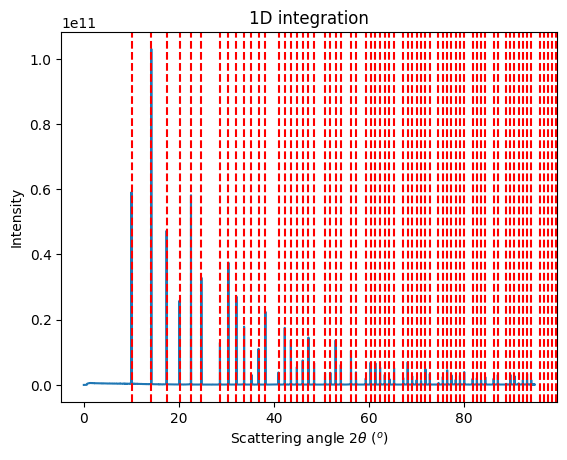

In [21]:
# Plot the integrated pattern vs expected peak positions:

LaB6_new = get_calibrant("LaB6")
LaB6_new.wavelength = hc/gonioref0.param[-1]*1e-10
p = jupyter.plot1d(res_mg, calibrant=LaB6_new)
p.figure.show()

In [22]:
#Peak profile function based on a bilinear interpolations: 

def calc_fwhm(integrate_result, calibrant, tth_min=None, tth_max=None):
    "calculate the tth position and FWHM for each peak"
    delta = integrate_result.intensity[1:] - integrate_result.intensity[:-1]
    maxima = numpy.where(numpy.logical_and(delta[:-1]>0, delta[1:]<0))[0]
    minima = numpy.where(numpy.logical_and(delta[:-1]<0, delta[1:]>0))[0]
    maxima += 1
    minima += 1
    tth = []
    FWHM = []
    if tth_min is None:
        tth_min = integrate_result.radial[0]
    if tth_max is None:
        tth_max = integrate_result.radial[-1]
    for tth_rad in calibrant.get_2th():
        tth_deg = tth_rad*integrate_result.unit.scale
        if (tth_deg<=tth_min) or (tth_deg>=tth_max):
            continue
        idx_theo = abs(integrate_result.radial-tth_deg).argmin()
        id0_max = abs(maxima-idx_theo).argmin()
        id0_min = abs(minima-idx_theo).argmin()
        I_max = integrate_result.intensity[maxima[id0_max]]
        I_min = integrate_result.intensity[minima[id0_min]]
        tth_maxi = integrate_result.radial[maxima[id0_max]]
        I_thres = (I_max + I_min)/2.0
        if minima[id0_min]>maxima[id0_max]:
            if id0_min == 0:
                min_lo = integrate_result.radial[0]
            else:
                min_lo = integrate_result.radial[minima[id0_min-1]]
            min_hi = integrate_result.radial[minima[id0_min]]
        else:
            if id0_min == len(minima) -1:
                min_hi = integrate_result.radial[-1]
            else:
                min_hi = integrate_result.radial[minima[id0_min+1]]
            min_lo = integrate_result.radial[minima[id0_min]]
            
        f = interp1d(integrate_result.radial, integrate_result.intensity-I_thres)
        try:
            tth_lo = bisect(f, min_lo, tth_maxi)
            tth_hi = bisect(f, tth_maxi, min_hi)
        except:
            pass
        else:
            FWHM.append(tth_hi-tth_lo)
            tth.append(tth_deg)
    return tth, FWHM
    


In [23]:
# Peak error:

def calc_peak_error(integrate_result, calibrant, tth_min=10, tth_max=95):
    "calculate the tth position and FWHM for each peak"
    peaks = find_peaks_cwt(integrate_result.intensity, [10])
    df = numpy.gradient(integrate_result.intensity)
    d2f = numpy.gradient(df)
    bad = d2f==0
    d2f[bad] = 1e-10
    cor = df / d2f
    print((abs(cor)>1).sum())
    cor[abs(cor)>1] = 0
    cor[bad] = 0
    got = numpy.interp(peaks-cor[peaks], 
                       numpy.arange(len(integrate_result.radial)), 
                       integrate_result.radial)
    mask = numpy.logical_and(got>=tth_min,
                             got<=tth_max)
    got = got[mask]
    target = numpy.array(calibrant.get_2th())*integrate_result.unit.scale
    mask = numpy.logical_and(target>=tth_min,
                             target<=tth_max)
    target = target[mask]
    print(len(got), len(target))
    d2 = distance_matrix(target.reshape(-1, 1 ),
                         got.reshape(-1, 1), p=1)
    
    return target, target-got[d2.argmin(axis=-1)]


29218
81 60


/tmp/ipykernel_367778/55614379.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


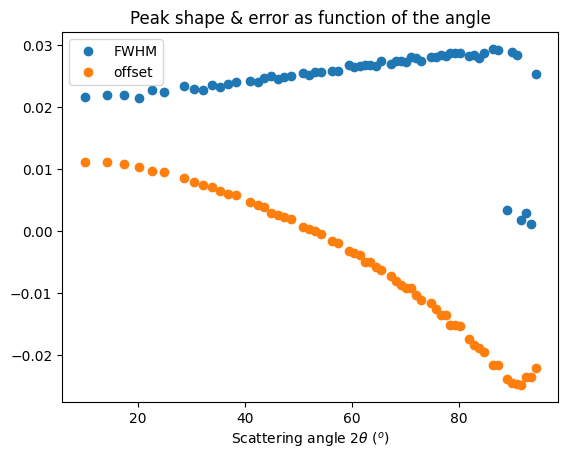

In [24]:
fig, ax = plt.subplots()
ax.plot(*calc_fwhm(res_mg, LaB6_new), "o", label="FWHM")
ax.plot(*calc_peak_error(res_mg, LaB6_new), "o", label="offset")
ax.set_title("Peak shape & error as function of the angle")
ax.set_xlabel(res_mg.unit.label)
ax.legend()
fig.show()

## Module 1 

We can apply the same procdure for the second module ... and try to rationalize the procedure.

In [25]:
module_id = 1
name = ds_names[module_id]
ds = data[name]
zero_pos = 64
frame_start = 103
frame_stop = 123

In [26]:
param1 = {"dist": 0.72, 
          "poni1": 640*50e-6, 
          "poni2": 4e-3, 
          "rot1":0, 
          "offset": -get_position(zero_pos), 
          "scale":1, 
          "nrj": nrj}

#Lock enegy for now and a couple of other parameters
bounds1 = {"nrj": (nrj, nrj),
           "dist": (0.7, 0.8),
           "poni2": (4e-3, 4e-3),
           "rot1": (0,0),
           "scale":(1,1), }

gonioref1 = GoniometerRefinement(param1, 
                                 get_position, 
                                 trans, 
                                 detector=modules[name], 
                                 wavelength=wl, 
                                 bounds=bounds1
                                 )
print(gonioref1)
goniometers[name]=gonioref1

GoniometerRefinement with 0 geometries labeled: .


In [27]:
#Exctract frames with peak#0
for i in range(frame_start, frame_stop):
    cp = ControlPoints(calibrant=LaB6, wavelength=wl)
    peak = peak_picking(name, i)
    if len(peak)!=1: 
        continue
    cp.append([peak[0]], ring=0)
    img = (ds[i]).reshape((-1,1))
    sg = gonioref1.new_geometry("%s_%04i"%(name,i), 
                                image=img, 
                                metadata=i, 
                                control_points=cp, 
                                calibrant=LaB6)
    sg.geometry_refinement.data = numpy.array(cp.getList())

print(gonioref1)
print(gonioref1.chi2())

GoniometerRefinement with 20 geometries labeled: data_03_0103, data_03_0104, data_03_0105, data_03_0106, data_03_0107, data_03_0108, data_03_0109, data_03_0110, data_03_0111, data_03_0112, data_03_0113, data_03_0114, data_03_0115, data_03_0116, data_03_0117, data_03_0118, data_03_0119, data_03_0120, data_03_0121, data_03_0122.
1.4524664758918932e-06


In [28]:
gonioref1.refine2()

Cost function before refinement: 1.4524664758918932e-06
[ 7.20000000e-01  3.20000000e-02  4.00000000e-03  0.00000000e+00
 -7.72000000e+01  1.00000000e+00  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.343186420609047e-11
       x: [ 7.200e-01  3.287e-02  4.000e-03  0.000e+00 -7.720e+01
            1.000e+00  1.703e+01]
     nit: 2
     jac: [ 1.374e-07  1.035e-07        nan        nan  9.897e-10
                  nan        nan]
    nfev: 9
    njev: 2
Cost function after refinement: 2.343186420609047e-11
GonioParam(dist=0.7200063780235467, poni1=0.03286839545438533, poni2=0.004, rot1=0.0, offset=-77.19998908851593, scale=1.0, nrj=17.027082549190933)
maxdelta on: poni1 (1) 0.032 --> 0.03286839545438533


array([ 7.20006378e-01,  3.28683955e-02,  4.00000000e-03,  0.00000000e+00,
       -7.71999891e+01,  1.00000000e+00,  1.70270825e+01])

In [29]:
#Exctract all frames with peak>0
tths = LaB6.get_2th()
#print(tths)
for i in range(frame_stop, ds.shape[0]):
    frame_name = "%s_%04i"%(name, i)
    if frame_name in gonioref1.single_geometries:
        continue
    peak = peak_picking(name, i)
    ai=gonioref1.get_ai(get_position(i))
    tth = ai.array_from_unit(unit="2th_rad", scale=False)
    tth_low = tth[20]
    tth_hi = tth[-20]
    ttmin, ttmax = min(tth_low, tth_hi), max(tth_low, tth_hi)
    valid_peaks = numpy.logical_and(ttmin<=tths, tths<ttmax)
    cnt = valid_peaks.sum()
    if (len(peak) ==  cnt) and cnt>0:    
        cp = ControlPoints(calibrant=LaB6, wavelength=wl)
        #revert the order of assignment if needed !!
        if tth_hi < tth_low:
            peak = peak[-1::-1]
        for p, r in zip(peak, numpy.where(valid_peaks)[0]):
            cp.append([p], ring=r)
        img = ds[i].reshape((-1,1))
        sg = gonioref1.new_geometry(frame_name, 
                                    image=img, 
                                    metadata=i, 
                                    control_points=cp, 
                                    calibrant=LaB6)
        sg.geometry_refinement.data = numpy.array(cp.getList())
        #print(frame_name, len(sg.geometry_refinement.data))

print(" Number of peaks found and used for refinement")
print(sum([len(sg.geometry_refinement.data) for sg in gonioref1.single_geometries.values()]))
print("Residual error before fitting: ", gonioref1.chi2())

 Number of peaks found and used for refinement
1183
Residual error before fitting:  6.334637850688808e-07


In [30]:
gonioref1.refine2()
gonioref1.set_bounds("poni1", -1, 1)
gonioref1.set_bounds("poni2", -1, 1)
gonioref1.set_bounds("rot1", -1, 1)
gonioref1.set_bounds("scale", 0.9, 1.1)
gonioref1.refine2()

Cost function before refinement: 6.334637850688808e-07
[ 7.20006378e-01  3.28683955e-02  4.00000000e-03  0.00000000e+00
 -7.71999891e+01  1.00000000e+00  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.3797258269094543e-07
       x: [ 7.200e-01  3.338e-02  4.000e-03  0.000e+00 -7.720e+01
            1.000e+00  1.703e+01]
     nit: 2
     jac: [-4.626e-07  2.408e-08        nan        nan  1.330e-11
                  nan        nan]
    nfev: 9
    njev: 2
Cost function after refinement: 1.3797258269094543e-07
GonioParam(dist=0.7200063394925221, poni1=0.033375469748006405, poni2=0.004, rot1=0.0, offset=-77.1999827124022, scale=1.0, nrj=17.027082549190933)
maxdelta on: poni1 (1) 0.03286839545438533 --> 0.033375469748006405
Cost function before refinement: 1.3797258269094543e-07
[ 7.20006339e-01  3.33754697e-02  4.00000000e-03  0.00000000e+00
 -7.71999827e+01  1.00000000e+00  1.70270825e+01]
 message: Optimization terminated successfull

array([ 7.20682073e-01,  3.36782330e-02,  4.05801069e-03, -4.44855685e-05,
       -7.71999788e+01,  9.98967233e-01,  1.70270825e+01])

In [31]:
mg1 = gonioref1.get_mg(position)
mg1.radial_range = (0, 95)
images = [i.reshape(-1, 1) for i in data[name]]
res_mg1 = mg1.integrate1d(images, 50000)
results[name] = res_mg1

/tmp/ipykernel_367778/3210620731.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.figure.show()


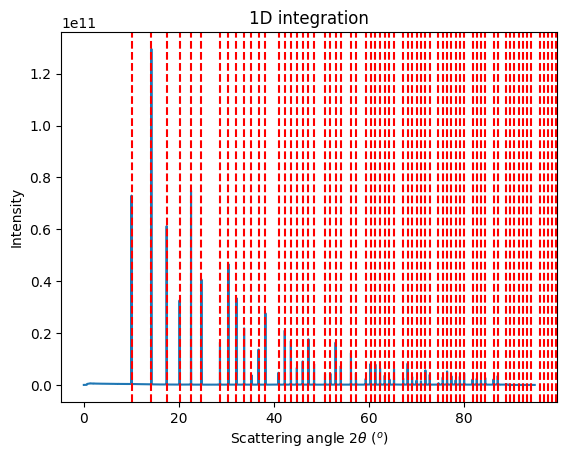

In [32]:
LaB6_new = get_calibrant("LaB6")
LaB6_new.wavelength = hc/gonioref1.param[-1]*1e-10
p = jupyter.plot1d(res_mg1, calibrant=LaB6_new)
p.figure.show()

27712
72 53


/tmp/ipykernel_367778/2659044189.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


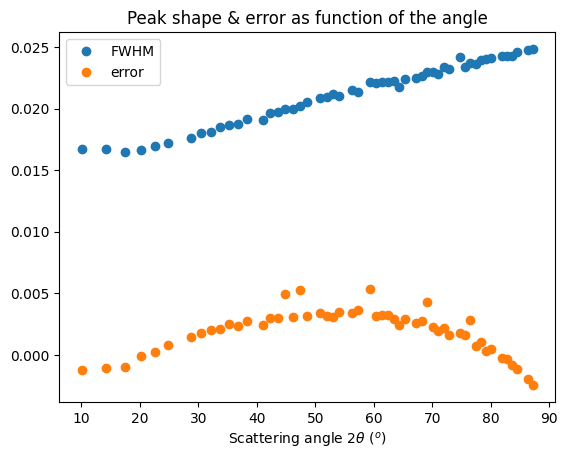

In [33]:
fig, ax = plt.subplots()
ax.plot(*calc_fwhm(res_mg1, LaB6_new, 10, 88), "o", label="FWHM")
ax.plot(*calc_peak_error(res_mg1, LaB6_new, 10, 88), "o", label="error")
ax.set_title("Peak shape & error as function of the angle")
ax.set_xlabel(res_mg.unit.label)
ax.legend()
fig.show()

## All other Modules

We define now an automatic procedure for any module. 
The detection used 3 parameter visually extracted from the Figure1: 

* zero_pos: the frame where the beam-stop is in the center of the module
* frame_start: the frame where the first peak of LaB6 appears (positive)
* frame_stop: the frame where the second peak of LaB6 appears (positive)

This is enough for boot-strapping the goniometer configuration.

In [34]:
def add_module(name,
               zero_pos,
               frame_start,
               frame_stop,
                ):
    ds = data[name]
    param = {"dist": 0.72, 
          "poni1": 640*50e-6, 
          "poni2": 4e-3, 
          "rot1":0, 
          "offset": -get_position(zero_pos), 
          "scale":1, 
          "nrj": nrj}

    #Lock enegy for now and a couple of other parameters
    bounds = {"nrj": (nrj, nrj),
              "dist": (0.7, 0.8),
              "poni2": (4e-3, 4e-3),
              "rot1": (0,0),
              "scale": (1,1)}

    gonioref = GoniometerRefinement(param, 
                                    get_position, 
                                    trans, 
                                    detector=modules[name], 
                                    wavelength=wl, 
                                    bounds=bounds
                                      )
    goniometers[name] = gonioref
    
    for i in range(frame_start, frame_stop):
        cp = ControlPoints(calibrant=LaB6, wavelength=wl)
        peak = peak_picking(name, i)
        if len(peak)!=1: 
            continue
        cp.append([peak[0]], ring=0)
        img = (ds[i]).reshape((-1,1))
        sg = gonioref.new_geometry("%s_%04i"%(name, i), 
                                    image=img, 
                                    metadata=i, 
                                    control_points=cp, 
                                    calibrant=LaB6)
        sg.geometry_refinement.data = numpy.array(cp.getList())

    print(gonioref.chi2())
    gonioref.refine2()
        
    tths = LaB6.get_2th()
    #print(tths)
    for i in range(frame_stop, ds.shape[0]):
        frame_name = "%s_%04i"%(name, i)
        if frame_name in gonioref.single_geometries:
            continue
        peak = peak_picking(name, i)
        ai=gonioref.get_ai(get_position(i))
        tth = ai.array_from_unit(unit="2th_rad", scale=False)
        tth_low = tth[20]
        tth_hi = tth[-20]
        ttmin, ttmax = min(tth_low, tth_hi), max(tth_low, tth_hi)
        valid_peaks = numpy.logical_and(ttmin<=tths, tths<ttmax)
        cnt = valid_peaks.sum()
        if (len(peak) ==  cnt) and cnt>0:    
            cp = ControlPoints(calibrant=LaB6, wavelength=wl)
            #revert the order of assignment if needed !!
            if tth_hi < tth_low:
                peak = peak[-1::-1]

            for p, r in zip(peak, numpy.where(valid_peaks)[0]):
                cp.append([p], ring=r)
            img = (ds[i]).reshape((-1,1))
            sg = gonioref.new_geometry(frame_name, 
                                        image=img, 
                                        metadata=i, 
                                        control_points=cp, 
                                        calibrant=LaB6)
            sg.geometry_refinement.data = numpy.array(cp.getList())
            #print(frame_name, len(sg.geometry_refinement.data))


    print(" Number of peaks found and used for refinement")
    print(sum([len(sg.geometry_refinement.data) for sg in gonioref.single_geometries.values()]))

    gonioref.refine2()
    gonioref.set_bounds("poni1", -1, 1)
    gonioref.set_bounds("poni2", -1, 1)
    gonioref.set_bounds("rot1", -1, 1)
    gonioref.set_bounds("scale", 0.9, 1.1)
    gonioref.refine2()
    
    mg = gonioref.get_mg(position)
    mg.radial_range = (0, 95)
    images = [i.reshape(-1, 1) for i in ds]
    res_mg = mg.integrate1d(images, 50000)
    results[name] = res_mg
    
    LaB6_new = get_calibrant("LaB6")
    LaB6_new.wavelength = hc/gonioref.param[-1]*1e-10
    p = jupyter.plot1d(res_mg, calibrant=LaB6_new)
    p.figure.show()
    
    fig, ax = plt.subplots()
    ax.plot(*calc_fwhm(res_mg, LaB6_new), "o", label="FWHM")
    ax.plot(*calc_peak_error(res_mg, LaB6_new, 10, 89), "o", label="error")
    ax.set_title("Peak shape & error as function of the angle")
    ax.set_xlabel(res_mg.unit.label)
    ax.legend()
    fig.show()

8.40633024472856e-06
Cost function before refinement: 8.40633024472856e-06
[ 7.20000000e-01  3.20000000e-02  4.00000000e-03  0.00000000e+00
 -7.15999445e+01  1.00000000e+00  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.8085719501136514e-11
       x: [ 7.200e-01  3.409e-02  4.000e-03  0.000e+00 -7.160e+01
            1.000e+00  1.703e+01]
     nit: 2
     jac: [ 4.574e-08  8.170e-07        nan        nan  9.916e-09
                  nan        nan]
    nfev: 9
    njev: 2
Cost function after refinement: 1.8085719501136514e-11
GonioParam(dist=0.7200189604924729, poni1=0.034089307266644636, poni2=0.004, rot1=0.0, offset=-71.59991818231154, scale=1.0, nrj=17.027082549190933)
maxdelta on: poni1 (1) 0.032 --> 0.034089307266644636
 Number of peaks found and used for refinement
1093
Cost function before refinement: 5.557202432497131e-07
[ 7.20018960e-01  3.40893073e-02  4.00000000e-03  0.00000000e+00
 -7.15999182e+01  1.00000000e+00  1.7

/tmp/ipykernel_367778/465879643.py:99: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.figure.show()


25659
71 54


/tmp/ipykernel_367778/465879643.py:107: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


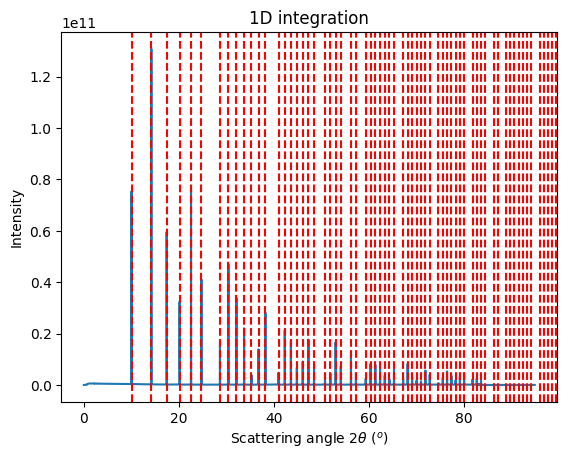

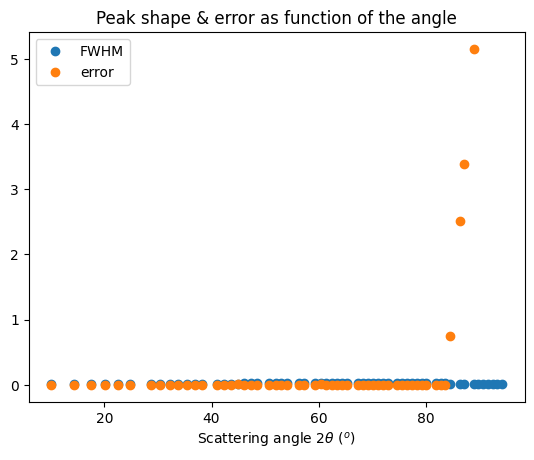

In [35]:
add_module(ds_names[2],
           92,
           131,
           151)

1.0825377842185958e-06
Cost function before refinement: 1.0825377842185958e-06
[ 7.20000000e-01  3.20000000e-02  4.00000000e-03  0.00000000e+00
 -6.57999444e+01  1.00000000e+00  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.4921937668954493e-11
       x: [ 7.200e-01  3.275e-02  4.000e-03  0.000e+00 -6.580e+01
            1.000e+00  1.703e+01]
     nit: 2
     jac: [-8.600e-08  7.994e-08        nan        nan  6.189e-10
                  nan        nan]
    nfev: 9
    njev: 2
Cost function after refinement: 2.4921937668954493e-11
GonioParam(dist=0.7200067449756247, poni1=0.03274966118487238, poni2=0.004, rot1=0.0, offset=-65.7999350248995, scale=1.0, nrj=17.027082549190933)
maxdelta on: poni1 (1) 0.032 --> 0.03274966118487238
 Number of peaks found and used for refinement
978
Cost function before refinement: 4.7051020473788555e-07
[ 7.20006745e-01  3.27496612e-02  4.00000000e-03  0.00000000e+00
 -6.57999350e+01  1.00000000e+00  1.

/tmp/ipykernel_367778/465879643.py:99: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.figure.show()


24026
64 54


/tmp/ipykernel_367778/465879643.py:107: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


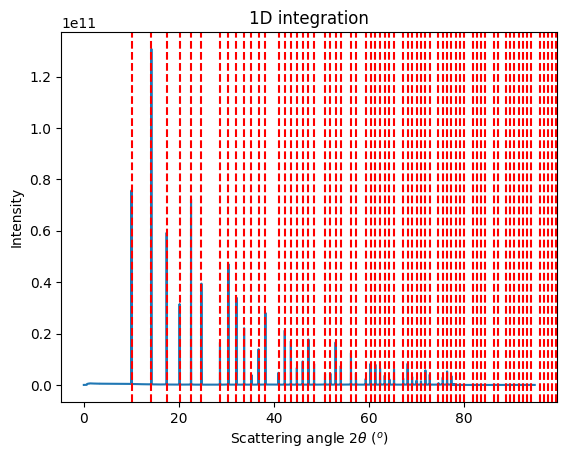

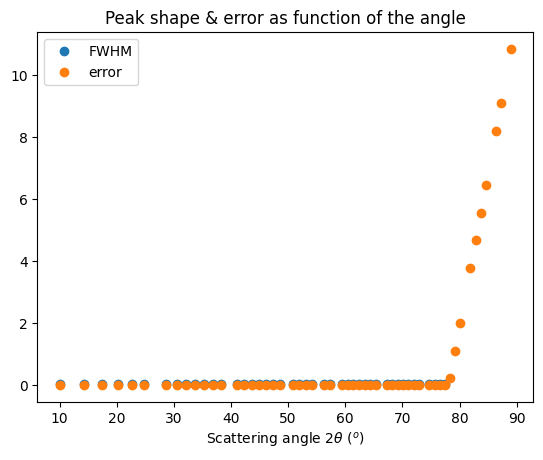

In [36]:
add_module(ds_names[3],
           121,
           159,
           179)

2.3193001243857842e-07
Cost function before refinement: 2.3193001243857842e-07
[ 7.20000000e-01  3.20000000e-02  4.00000000e-03  0.00000000e+00
 -6.00000556e+01  1.00000000e+00  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.085662476197838e-10
       x: [ 7.200e-01  3.165e-02  4.000e-03  0.000e+00 -6.000e+01
            1.000e+00  1.703e+01]
     nit: 2
     jac: [-2.720e-07  2.346e-08        nan        nan -9.145e-11
                  nan        nan]
    nfev: 9
    njev: 2
Cost function after refinement: 2.085662476197838e-10
GonioParam(dist=0.7199968842266145, poni1=0.03165314623342505, poni2=0.004, rot1=0.0, offset=-60.00005992107673, scale=1.0, nrj=17.027082549190933)
maxdelta on: poni1 (1) 0.032 --> 0.03165314623342505
 Number of peaks found and used for refinement
864
Cost function before refinement: 3.8832764505567803e-07
[ 7.19996884e-01  3.16531462e-02  4.00000000e-03  0.00000000e+00
 -6.00000599e+01  1.00000000e+00  1.7

/tmp/ipykernel_367778/465879643.py:99: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.figure.show()


22251
56 54


/tmp/ipykernel_367778/465879643.py:107: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


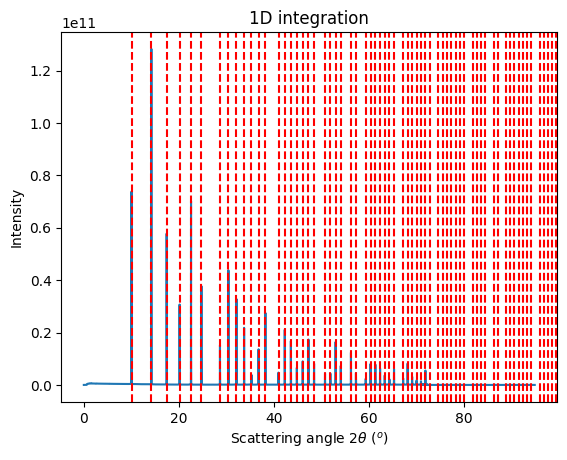

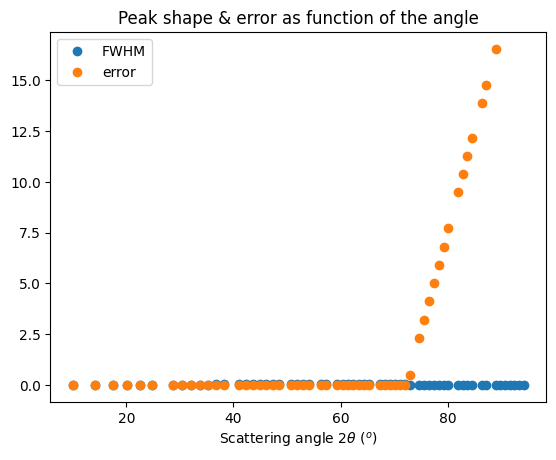

In [37]:
add_module(ds_names[4],
           150,
           188,
           208)

1.4965819410817478e-06
Cost function before refinement: 1.4965819410817478e-06
[ 7.20000000e-01  3.20000000e-02  4.00000000e-03  0.00000000e+00
 -5.43998333e+01  1.00000000e+00  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.0171535049901094e-10
       x: [ 7.200e-01  3.288e-02  4.000e-03  0.000e+00 -5.440e+01
            1.000e+00  1.703e+01]
     nit: 2
     jac: [-2.790e-07  1.127e-07        nan        nan  1.017e-09
                  nan        nan]
    nfev: 9
    njev: 2
Cost function after refinement: 2.0171535049901094e-10
GonioParam(dist=0.7200081377942467, poni1=0.03288139794526324, poni2=0.004, rot1=0.0, offset=-54.39982225664511, scale=1.0, nrj=17.027082549190933)
maxdelta on: poni1 (1) 0.032 --> 0.03288139794526324
 Number of peaks found and used for refinement
754
Cost function before refinement: 3.084364539629558e-07
[ 7.20008138e-01  3.28813979e-02  4.00000000e-03  0.00000000e+00
 -5.43998223e+01  1.00000000e+00  1.

/tmp/ipykernel_367778/465879643.py:99: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.figure.show()


20549
54 54


/tmp/ipykernel_367778/465879643.py:107: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


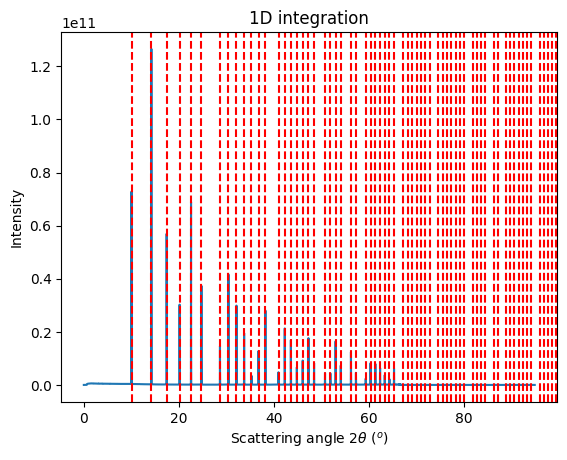

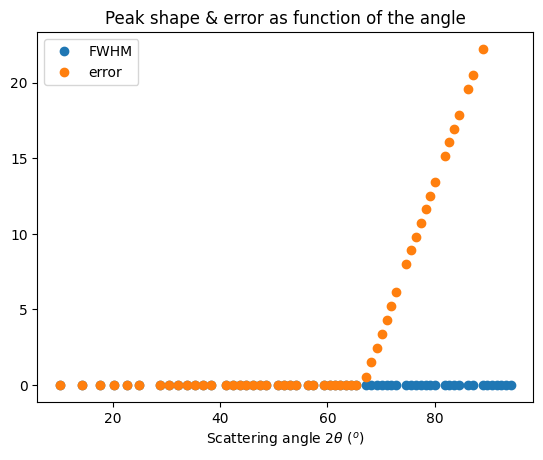

In [38]:
add_module(ds_names[5],
           178,
           216,
           236)

7.41484379835199e-08
Cost function before refinement: 7.41484379835199e-08
[ 7.20000000e-01  3.20000000e-02  4.00000000e-03  0.00000000e+00
 -4.85998889e+01  1.00000000e+00  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 5.651340369404608e-11
       x: [ 7.200e-01  3.180e-02  4.000e-03  0.000e+00 -4.860e+01
            1.000e+00  1.703e+01]
     nit: 2
     jac: [-2.813e-07  1.905e-08        nan        nan -1.234e-10
                  nan        nan]
    nfev: 9
    njev: 2
Cost function after refinement: 5.651340369404608e-11
GonioParam(dist=0.7199985717445607, poni1=0.03180385768846998, poni2=0.004, rot1=0.0, offset=-48.599891358723, scale=1.0, nrj=17.027082549190933)
maxdelta on: poni1 (1) 0.032 --> 0.03180385768846998
 Number of peaks found and used for refinement
626
Cost function before refinement: 2.383303034849477e-07
[ 7.19998572e-01  3.18038577e-02  4.00000000e-03  0.00000000e+00
 -4.85998914e+01  1.00000000e+00  1.70270825

/tmp/ipykernel_367778/465879643.py:99: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.figure.show()


18650
54 54


/tmp/ipykernel_367778/465879643.py:107: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


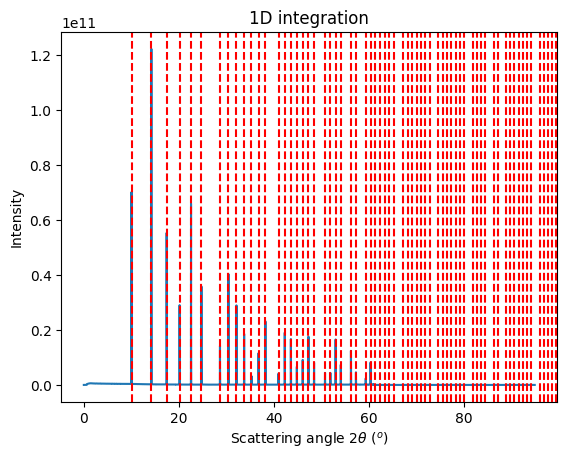

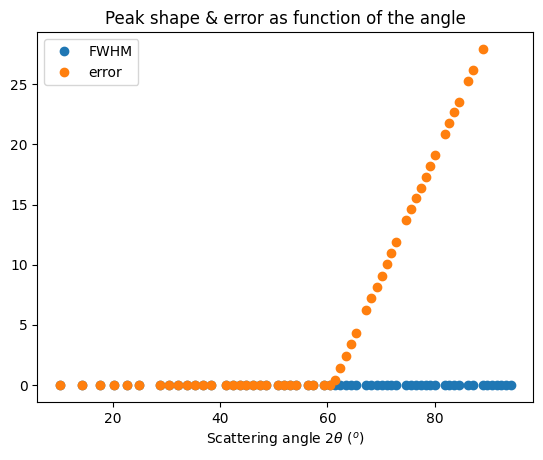

In [39]:
add_module(ds_names[6],
           207,
           245,
           266)

4.377487894658635e-06
Cost function before refinement: 4.377487894658635e-06
[ 7.20000000e-01  3.20000000e-02  4.00000000e-03  0.00000000e+00
 -4.27998889e+01  1.00000000e+00  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 9.109058146293743e-11
       x: [ 7.200e-01  3.049e-02  4.000e-03  0.000e+00 -4.280e+01
            1.000e+00  1.703e+01]
     nit: 2
     jac: [-3.538e-07  3.502e-09        nan        nan -3.652e-10
                  nan        nan]
    nfev: 9
    njev: 2
Cost function after refinement: 9.109058146293743e-11
GonioParam(dist=0.7199860337927957, poni1=0.030492505461750096, poni2=0.004, rot1=0.0, offset=-42.79990784449265, scale=1.0, nrj=17.027082549190933)
maxdelta on: poni1 (1) 0.032 --> 0.030492505461750096
 Number of peaks found and used for refinement
543
Cost function before refinement: 1.911534453472336e-07
[ 7.19986034e-01  3.04925055e-02  4.00000000e-03  0.00000000e+00
 -4.27999078e+01  1.00000000e+00  1.70

/tmp/ipykernel_367778/465879643.py:99: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.figure.show()


16803
45 54


/tmp/ipykernel_367778/465879643.py:107: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


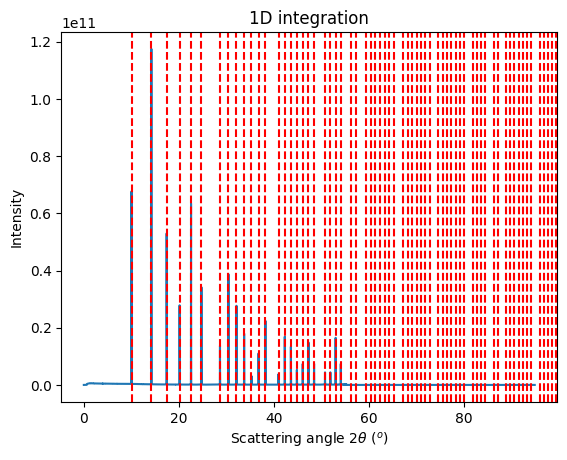

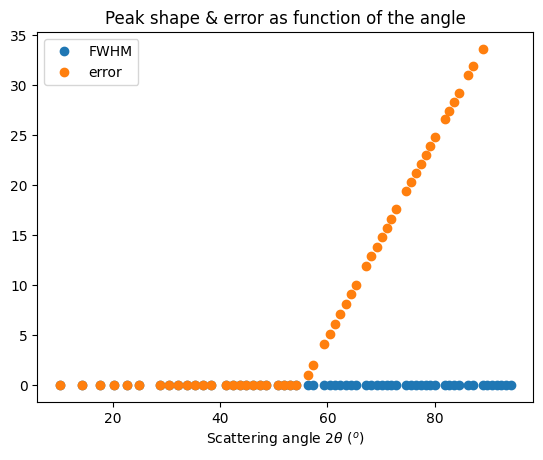

In [40]:
add_module(ds_names[7],
           236,
           273,
           293)

9.734136493812279e-08
Cost function before refinement: 9.734136493812279e-08
[ 7.20000000e-01  3.20000000e-02  4.00000000e-03  0.00000000e+00
 -3.72000000e+01  1.00000000e+00  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.383834659393779e-10
       x: [ 7.200e-01  3.178e-02  4.000e-03  0.000e+00 -3.720e+01
            1.000e+00  1.703e+01]
     nit: 2
     jac: [-5.987e-07  2.236e-08        nan        nan -2.112e-10
                  nan        nan]
    nfev: 9
    njev: 2
Cost function after refinement: 1.383834659393779e-10
GonioParam(dist=0.7199980533133431, poni1=0.0317753490052087, poni2=0.004, rot1=0.0, offset=-37.20000282728478, scale=1.0, nrj=17.027082549190933)
maxdelta on: poni1 (1) 0.032 --> 0.0317753490052087
 Number of peaks found and used for refinement
454
Cost function before refinement: 1.4308139309115986e-07
[ 7.19998053e-01  3.17753490e-02  4.00000000e-03  0.00000000e+00
 -3.72000028e+01  1.00000000e+00  1.70270

/tmp/ipykernel_367778/465879643.py:99: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.figure.show()


16875
45 54


/tmp/ipykernel_367778/465879643.py:107: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


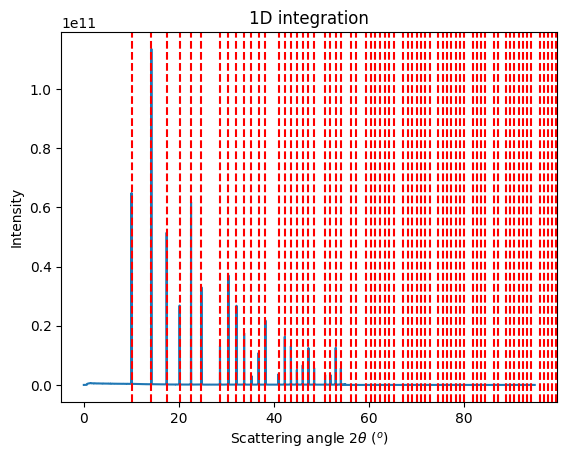

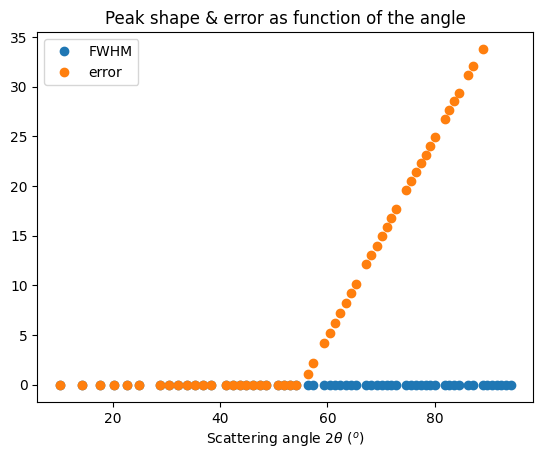

In [41]:
add_module(ds_names[8],
           264,
           302,
           322)

In [42]:
len(goniometers)

9

In [43]:
# print all the parameters to be able to compare them visually
goniometers["data_12"] = goniometers["data_11"]
for name in ds_names:
    print(name, *["%8.4e"%i for i in goniometers[name].param])

data_02 7.2310e-01 3.2054e-02 3.9849e-03 1.0948e-05 -8.2800e+01 9.9942e-01 1.7027e+01
data_03 7.2068e-01 3.3678e-02 4.0580e-03 -4.4486e-05 -7.7200e+01 9.9897e-01 1.7027e+01
data_04 7.2069e-01 3.4825e-02 4.0432e-03 -3.3768e-05 -7.1600e+01 9.9898e-01 1.7027e+01
data_05 7.2048e-01 3.3410e-02 3.9779e-03 1.5910e-05 -6.5800e+01 9.9900e-01 1.7027e+01
data_07 7.2065e-01 3.2237e-02 3.9757e-03 1.7542e-05 -6.0000e+01 9.9901e-01 1.7027e+01
data_08 7.2053e-01 3.3395e-02 3.9730e-03 1.9484e-05 -5.4400e+01 9.9903e-01 1.7027e+01
data_09 7.2061e-01 3.2247e-02 3.9689e-03 2.2375e-05 -4.8600e+01 9.9904e-01 1.7027e+01
data_10 7.2071e-01 3.0863e-02 3.9652e-03 2.5070e-05 -4.2800e+01 9.9905e-01 1.7027e+01
data_11 7.2081e-01 3.2082e-02 3.9596e-03 2.9091e-05 -3.7200e+01 9.9906e-01 1.7027e+01
data_12 7.2081e-01 3.2082e-02 3.9596e-03 2.9091e-05 -3.7200e+01 9.9906e-01 1.7027e+01


## Use the negative part of the spectum ...

Until now, we used only the data where 2th >0 
For the last modules, this thows away half of the data.

We setup here a way to assign the peaks for the negative part of the spectrum.

In [44]:
def complete_gonio(module_id=None, name=None):
    "Scan missing frames for un-indexed peaks"
    if name is None:
        name = ds_names[module_id]
    gonioref = goniometers[name]
    ds = data[name]
    print("Number of peaks previously found:",
           sum([len(sg.geometry_refinement.data) for sg in gonioref.single_geometries.values()]))

    tths = LaB6.get_2th()

    for i in range(ds.shape[0]):
        frame_name = "%s_%04i"%(name, i)
        if frame_name in gonioref.single_geometries:
                continue
        peak = peak_picking(name, i)
        ai=gonioref.get_ai(get_position(i))
        tth = ai.array_from_unit(unit="2th_rad", scale=False)
        tth_low = tth[20]
        tth_hi = tth[-20]
        ttmin, ttmax = min(tth_low, tth_hi), max(tth_low, tth_hi)
        valid_peaks = numpy.logical_and(ttmin<=tths, tths<ttmax)
        cnt = valid_peaks.sum()
        if (len(peak) ==  cnt) and cnt>0:    
            cp = ControlPoints(calibrant=LaB6, wavelength=wl)
            #revert the order of assignment if needed !!
            if tth_hi < tth_low:
                peak = peak[-1::-1]
            for p, r in zip(peak, numpy.where(valid_peaks)[0]):
                cp.append([p], ring=r)
            img = ds[i].reshape((-1,1))
            sg = gonioref.new_geometry(frame_name, 
                                        image=img, 
                                        metadata=i, 
                                        control_points=cp, 
                                        calibrant=LaB6)
            sg.geometry_refinement.data = numpy.array(cp.getList())
            #print(frame_name, len(sg.geometry_refinement.data))

    print("Number of peaks found after re-scan:",
            sum([len(sg.geometry_refinement.data) for sg in gonioref.single_geometries.values()]))
    return gonioref

In [45]:
gonio8 = complete_gonio(module_id=8)
gonio8.refine2()

Number of peaks previously found: 454
Number of peaks found after re-scan: 1006
Cost function before refinement: 4.707082320757526e-09
[ 7.20810786e-01  3.20817564e-02  3.95963363e-03  2.90905935e-05
 -3.71999988e+01  9.99058854e-01  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 9.802713851439468e-10
       x: [ 7.208e-01  3.208e-02  3.962e-03  2.771e-05 -3.720e+01
            9.990e-01  1.703e+01]
     nit: 4
     jac: [-8.293e-07  1.798e-08 -2.226e-07  1.638e-07 -1.374e-10
           -3.004e-08        nan]
    nfev: 29
    njev: 4
Cost function after refinement: 9.802713851439468e-10
GonioParam(dist=0.7208134358051861, poni1=0.03208491868712114, poni2=0.003961539924237118, rot1=2.7705794268123684e-05, offset=-37.19999878573076, scale=0.9989913574692074, nrj=17.027082549190933)
maxdelta on: scale (5) 0.9990588539443465 --> 0.9989913574692074


array([ 7.20813436e-01,  3.20849187e-02,  3.96153992e-03,  2.77057943e-05,
       -3.71999988e+01,  9.98991357e-01,  1.70270825e+01])

In [46]:
gonio7 = complete_gonio(module_id=7)

Number of peaks previously found: 543
Number of peaks found after re-scan: 1004


In [47]:
gonio7.refine2()

Cost function before refinement: 2.0497716259840994e-09
[ 7.20707158e-01  3.08633924e-02  3.96520622e-03  2.50696615e-05
 -4.27999030e+01  9.99050606e-01  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 6.982166320635817e-10
       x: [ 7.207e-01  3.087e-02  3.967e-03  2.399e-05 -4.280e+01
            9.990e-01  1.703e+01]
     nit: 4
     jac: [-6.616e-07  1.821e-08 -2.311e-07  1.692e-07 -1.059e-10
           -2.989e-08        nan]
    nfev: 29
    njev: 4
Cost function after refinement: 6.982166320635817e-10
GonioParam(dist=0.720709214422471, poni1=0.03086624488803945, poni2=0.003966690771283648, rot1=2.39914176175178e-05, offset=-42.799902936946246, scale=0.9990066875067236, nrj=17.027082549190933)
maxdelta on: scale (5) 0.9990506059528655 --> 0.9990066875067236


array([ 7.20709214e-01,  3.08662449e-02,  3.96669077e-03,  2.39914176e-05,
       -4.27999029e+01,  9.99006688e-01,  1.70270825e+01])

In [48]:
gonio6 = complete_gonio(module_id=6)
gonio6.refine2()

Number of peaks previously found: 626
Number of peaks found after re-scan: 990
Cost function before refinement: 9.054149840019781e-10
[ 7.20609293e-01  3.22472572e-02  3.96893551e-03  2.23754877e-05
 -4.85998857e+01  9.99040908e-01  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 6.093707047210183e-10
       x: [ 7.206e-01  3.225e-02  3.970e-03  2.155e-05 -4.860e+01
            9.990e-01  1.703e+01]
     nit: 4
     jac: [-8.022e-07  3.637e-08 -2.332e-07  1.713e-07  1.531e-10
           -6.906e-08        nan]
    nfev: 29
    njev: 4
Cost function after refinement: 6.093707047210183e-10
GonioParam(dist=0.7206117522126192, poni1=0.03224903534974467, poni2=0.003970067520032141, rot1=2.154981768904857e-05, offset=-48.5998856370124, scale=0.999018042153128, nrj=17.027082549190933)
maxdelta on: scale (5) 0.9990409081096999 --> 0.999018042153128


array([ 7.20611752e-01,  3.22490353e-02,  3.97006752e-03,  2.15498177e-05,
       -4.85998856e+01,  9.99018042e-01,  1.70270825e+01])

In [49]:
gonio5 = complete_gonio(module_id=5)
gonio5.refine2()

Number of peaks previously found: 754
Number of peaks found after re-scan: 1038
Cost function before refinement: 5.322293562205405e-10
[ 7.20528266e-01  3.33948135e-02  3.97295117e-03  1.94836705e-05
 -5.43998157e+01  9.99025951e-01  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 5.247777068807799e-10
       x: [ 7.205e-01  3.340e-02  3.974e-03  1.898e-05 -5.440e+01
            9.990e-01  1.703e+01]
     nit: 4
     jac: [-6.548e-07  1.292e-07 -1.627e-07  1.198e-07  1.289e-09
           -2.774e-07        nan]
    nfev: 29
    njev: 4
Cost function after refinement: 5.247777068807799e-10
GonioParam(dist=0.7205306818871419, poni1=0.03339533863359239, poni2=0.003973636919054829, rot1=1.8979820018941428e-05, offset=-54.39981565738007, scale=0.9990218992357166, nrj=17.027082549190933)
maxdelta on: scale (5) 0.9990259510567647 --> 0.9990218992357166


array([ 7.20530682e-01,  3.33953386e-02,  3.97363692e-03,  1.89798200e-05,
       -5.43998157e+01,  9.99021899e-01,  1.70270825e+01])

In [50]:
gonio4 = complete_gonio(module_id=4)
gonio4.refine2()

Number of peaks previously found: 864
Number of peaks found after re-scan: 1081
Cost function before refinement: 4.522890520775561e-10
[ 7.20645308e-01  3.22371168e-02  3.97565157e-03  1.75422418e-05
 -6.00000524e+01  9.99011866e-01  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 4.329909092681409e-10
       x: [ 7.206e-01  3.224e-02  3.976e-03  1.742e-05 -6.000e+01
            9.990e-01  1.703e+01]
     nit: 4
     jac: [-3.236e-07 -1.338e-08 -8.079e-08  5.953e-08 -4.927e-10
            3.166e-08        nan]
    nfev: 29
    njev: 4
Cost function after refinement: 4.329909092681409e-10
GonioParam(dist=0.7206464175851856, poni1=0.032235988249254756, poni2=0.0039758195842887565, rot1=1.7416684299562826e-05, offset=-60.0000524507336, scale=0.9990197113116526, nrj=17.027082549190933)
maxdelta on: scale (5) 0.9990118655636463 --> 0.9990197113116526


array([ 7.20646418e-01,  3.22359882e-02,  3.97581958e-03,  1.74166843e-05,
       -6.00000525e+01,  9.99019711e-01,  1.70270825e+01])

In [51]:
gonio3 = complete_gonio(module_id=3)
gonio3.refine2()

Number of peaks previously found: 978
Number of peaks found after re-scan: 1156
Cost function before refinement: 7.053066247292853e-10
[ 7.20482925e-01  3.34099487e-02  3.97791164e-03  1.59098280e-05
 -6.57999266e+01  9.98999120e-01  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 6.316703213409536e-10
       x: [ 7.205e-01  3.341e-02  3.978e-03  1.605e-05 -6.580e+01
            9.990e-01  1.703e+01]
     nit: 4
     jac: [-4.998e-07 -1.632e-08  9.666e-09 -4.950e-09 -5.754e-10
            3.901e-08        nan]
    nfev: 29
    njev: 4
Cost function after refinement: 6.316703213409536e-10
GonioParam(dist=0.7204847939312276, poni1=0.033407488249092, poni2=0.003977700789209715, rot1=1.605421293874649e-05, offset=-65.79992658915752, scale=0.9990156265501503, nrj=17.027082549190933)
maxdelta on: scale (5) 0.9989991199293132 --> 0.9990156265501503


array([ 7.20484794e-01,  3.34074882e-02,  3.97770079e-03,  1.60542129e-05,
       -6.57999266e+01,  9.99015627e-01,  1.70270825e+01])

In [52]:
gonio2 = complete_gonio(module_id=2)
gonio2.refine2()

Number of peaks previously found: 1093
Number of peaks found after re-scan: 1229
Cost function before refinement: 8.306328970111712e-10
[ 7.20686429e-01  3.48247408e-02  4.04316628e-03 -3.37683836e-05
 -7.15999088e+01  9.98982873e-01  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 7.771718764214187e-10
       x: [ 7.207e-01  3.482e-02  4.043e-03 -3.357e-05 -7.160e+01
            9.990e-01  1.703e+01]
     nit: 4
     jac: [ 9.152e-08 -1.052e-09  5.616e-08 -4.083e-08 -4.257e-10
            2.851e-09        nan]
    nfev: 29
    njev: 4
Cost function after refinement: 7.771718764214187e-10
GonioParam(dist=0.7206860334374249, poni1=0.03482262187953887, poni2=0.004042896898550854, rot1=-3.357268964891843e-05, offset=-71.5999088383266, scale=0.9989982448525314, nrj=17.027082549190933)
maxdelta on: scale (5) 0.9989828730379465 --> 0.9989982448525314


array([ 7.20686033e-01,  3.48226219e-02,  4.04289690e-03, -3.35726896e-05,
       -7.15999088e+01,  9.98998245e-01,  1.70270825e+01])

In [53]:
gonio1 = complete_gonio(module_id=1)
gonio1.refine2()


Number of peaks previously found: 1183
Number of peaks found after re-scan: 1285
Cost function before refinement: 9.822430107504146e-10
[ 7.20682073e-01  3.36782330e-02  4.05801069e-03 -4.44855685e-05
 -7.71999788e+01  9.98967233e-01  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 9.683583561116745e-10
       x: [ 7.207e-01  3.368e-02  4.058e-03 -4.454e-05 -7.720e+01
            9.990e-01  1.703e+01]
     nit: 4
     jac: [ 1.052e-07 -1.409e-09 -2.647e-09  1.496e-09 -3.432e-10
            4.363e-09        nan]
    nfev: 29
    njev: 4
Cost function after refinement: 9.683583561116745e-10
GonioParam(dist=0.7206815883863531, poni1=0.03367666939027231, poni2=0.004058082314538765, rot1=-4.453529530230961e-05, offset=-77.19997881135367, scale=0.9989759056428863, nrj=17.027082549190933)
maxdelta on: scale (5) 0.9989672333399332 --> 0.9989759056428863


array([ 7.20681588e-01,  3.36766694e-02,  4.05808231e-03, -4.45352953e-05,
       -7.71999788e+01,  9.98975906e-01,  1.70270825e+01])

In [54]:
gonio0 = complete_gonio(module_id=0)
gonio0.refine2()

Number of peaks previously found: 1203
Number of peaks found after re-scan: 1255
Cost function before refinement: 2.580092915588822e-06
[ 7.23096244e-01  3.20537008e-02  3.98485488e-03  1.09477707e-05
 -8.27999440e+01  9.99415058e-01  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.5799879786031964e-06
       x: [ 7.231e-01  3.207e-02  3.981e-03  1.351e-05 -8.280e+01
            9.994e-01  1.703e+01]
     nit: 4
     jac: [-1.439e-07  3.613e-08  5.528e-07 -3.992e-07  1.022e-09
           -1.146e-07        nan]
    nfev: 29
    njev: 4
Cost function after refinement: 2.5799879786031964e-06
GonioParam(dist=0.7230969945154274, poni1=0.03206584438250582, poni2=0.003981302101258431, rot1=1.351375944293161e-05, offset=-82.79994383887343, scale=0.9993962397251773, nrj=17.027082549190933)
maxdelta on: scale (5) 0.9994150576486731 --> 0.9993962397251773


array([ 7.23096995e-01,  3.20658444e-02,  3.98130210e-03,  1.35137594e-05,
       -8.27999438e+01,  9.99396240e-01,  1.70270825e+01])

In [55]:
#Rescan module0 which looks much different:
gonio0.single_geometries.clear()
gonio0 = complete_gonio(module_id=0)
gonio0.refine2()

Number of peaks previously found: 0
Number of peaks found after re-scan: 1250
Cost function before refinement: 9.454139650039214e-07
[ 7.23096995e-01  3.20658444e-02  3.98130210e-03  1.35137594e-05
 -8.27999438e+01  9.99396240e-01  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 9.315197979050413e-07
       x: [ 7.220e-01  3.220e-02  3.944e-03  4.514e-05 -8.280e+01
            9.991e-01  1.703e+01]
     nit: 9
     jac: [-1.206e-08 -1.145e-08  1.037e-07 -7.484e-08  1.341e-10
           -9.527e-09        nan]
    nfev: 64
    njev: 9
Cost function after refinement: 9.315197979050413e-07
GonioParam(dist=0.7219737518819529, poni1=0.032200315169332513, poni2=0.003943811455063223, rot1=4.514209223007649e-05, offset=-82.79994226212274, scale=0.9991407871114438, nrj=17.027082549190933)
maxdelta on: dist (0) 0.7230969945154274 --> 0.7219737518819529


array([ 7.21973752e-01,  3.22003152e-02,  3.94381146e-03,  4.51420922e-05,
       -8.27999423e+01,  9.99140787e-01,  1.70270825e+01])

## Discard wronly assigned peaks

We have seen previously that some modules have a much higher residual error, while all have almost the same number of peaks recorded and fitted.

Some frames are contributing much more than all the other in those badly-fitted data. 
Let's spot them and re-assign them

In [56]:
#search for mis-assigned peaks in module #0
labels = []
errors = []

for lbl,sg in gonio0.single_geometries.items():
    labels.append(lbl)
    errors.append(sg.geometry_refinement.chi2())

s = numpy.argsort(errors)
for i in s[-10:]:
    print(labels[i], errors[i])
    
    

data_02_0455 6.313036491714458e-07
data_02_0464 6.523609473021892e-07
data_02_0465 6.891634832505096e-07
data_02_0457 7.370411378714757e-07
data_02_0456 7.376222637955442e-07
data_02_0460 7.458553094683675e-07
data_02_0466 7.671412675214738e-07
data_02_0461 7.935692964121192e-07
data_02_0462 7.971540266865079e-07
data_02_0480 0.0011307661026103302


In [57]:
#remove wrongly assigned peak for frame 480
print(gonio0.single_geometries.pop("data_02_0480").control_points)
gonio0.refine2()
gonio0 = complete_gonio(module_id=0)

gonio0.refine2()

ControlPoints instance containing 4 group of point:
LaB6 Calibrant with 109 reflections at wavelength 7.281587910025816e-11
Containing 4 groups of points:
#psg ring 52: 1 points
#psh ring 53: 1 points
#psi ring 54: 1 points
#psj ring 55: 1 points
Cost function before refinement: 8.041213618478122e-09
[ 7.21973752e-01  3.22003152e-02  3.94381146e-03  4.51420922e-05
 -8.27999423e+01  9.99140787e-01  1.70270825e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 9.214244602861188e-10
       x: [ 7.206e-01  3.228e-02  4.043e-03 -2.053e-05 -8.280e+01
            9.990e-01  1.703e+01]
     nit: 9
     jac: [-3.087e-08 -3.829e-08 -1.829e-07  1.319e-07 -8.443e-10
           -1.615e-08        nan]
    nfev: 64
    njev: 9
Cost function after refinement: 9.214244602861188e-10
GonioParam(dist=0.7205957894276002, poni1=0.032284408312060156, poni2=0.004042525656543217, rot1=-2.0533943479941534e-05, offset=-82.79994103817624, scale=0.9989751747980284, nrj=17.0270

array([ 7.20595796e-01,  3.22847938e-02,  4.04257343e-03, -2.05683995e-05,
       -8.27999410e+01,  9.98975186e-01,  1.70270825e+01])

In [58]:
def search_outliers(module_id=None, name=None, threshold=1.2):
    "Search for wrongly assigned peaks"
    if name is None:
        name = ds_names[module_id]
    gonioref = goniometers[name]
    labels = []
    errors = []

    for lbl,sg in gonioref.single_geometries.items():
        labels.append(lbl)
        errors.append(sg.geometry_refinement.chi2())
    s = numpy.argsort(errors)
    last = errors[s[-1]]
    to_remove = []
    for i in s[-1::-1]:
        lbl = labels[i]
        current = errors[i]
        print(lbl , current, last, last/current)
        if threshold*current<last:
            break
        last=current
        to_remove.append(lbl)
    return to_remove


        
for lbl in search_outliers(8):
    gonio8.single_geometries.pop(lbl)
gonio8.refine2()
gonio8 = complete_gonio(module_id=8)
gonio8.refine2()

data_11_0495 1.4653264249059768e-06 1.4653264249059768e-06 1.0
data_11_0496 1.4360706723755973e-06 1.4653264249059768e-06 1.02037208411337
data_11_0499 1.4166274579074244e-06 1.4360706723755973e-06 1.01372500184127
data_11_0497 1.408429897528043e-06 1.4166274579074244e-06 1.0058203538520227
data_11_0498 1.3832745250176507e-06 1.408429897528043e-06 1.0181853797315261
data_11_0500 1.3708837484730059e-06 1.3832745250176507e-06 1.0090385319385737
data_11_0492 1.3295635096461316e-06 1.3708837484730059e-06 1.031078048191825
data_11_0489 1.3287444389906674e-06 1.3295635096461316e-06 1.000616424521849
data_11_0491 1.3215889751725488e-06 1.3287444389906674e-06 1.0054142883699408
data_11_0490 1.301797579301906e-06 1.3215889751725488e-06 1.0152031284934913
data_11_0494 1.2865330382410883e-06 1.301797579301906e-06 1.0118648651896938
data_11_0493 1.2861198600876661e-06 1.2865330382410883e-06 1.0003212594457518
data_11_0483 1.2244247451147827e-06 1.2861198600876661e-06 1.0503870206960737
data_11_048

array([ 7.20813993e-01,  3.20850058e-02,  3.96170033e-03,  2.75879226e-05,
       -3.71999988e+01,  9.98991091e-01,  1.70270825e+01])

In [59]:
print(gonio7.chi2())
for lbl in search_outliers(7):
    gonio7.single_geometries.pop(lbl)
gonio7.refine2()
gonio7 = complete_gonio(module_id=7)
gonio7.refine2()

6.982166320635817e-10
data_10_0292 4.478313610295236e-06 4.478313610295236e-06 1.0
data_10_0291 4.441618075732054e-06 4.478313610295236e-06 1.008261749195339
data_10_0288 4.421114039991817e-06 4.441618075732054e-06 1.0046377531895274
data_10_0285 4.4151969079424084e-06 4.421114039991817e-06 1.0013401739883365
data_10_0290 4.4114083219467785e-06 4.4151969079424084e-06 1.0008588155344365
data_10_0289 4.40450577270408e-06 4.4114083219467785e-06 1.0015671563618955
data_10_0284 4.386350135873239e-06 4.40450577270408e-06 1.0041391216543243
data_10_0275 4.376873169865872e-06 4.386350135873239e-06 1.0021652366060354
data_10_0286 4.374944729160871e-06 4.376873169865872e-06 1.0004407920155303
data_10_0283 4.360029737297362e-06 4.374944729160871e-06 1.0034208463616476
data_10_0281 4.3581187741366675e-06 4.360029737297362e-06 1.0004384834970619
data_10_0282 4.3552714424913155e-06 4.3581187741366675e-06 1.0006537667474804
data_10_0278 4.352333646868408e-06 4.3552714424913155e-06 1.0006749932016406


array([ 7.20709497e-01,  3.08662382e-02,  3.96677261e-03,  2.39312903e-05,
       -4.27999029e+01,  9.99006774e-01,  1.70270825e+01])

In [60]:
print(gonio0.chi2())
print(len(search_outliers(0)))
# for lbl in search_outliers(7):
#     gonio7.single_geometries.pop(lbl)
# gonio7.refine2()
# gonio7 = complete_gonio(module_id=7)
# gonio7.refine2()

9.382098584456135e-10
data_02_0462 7.971540266865079e-07 7.971540266865079e-07 1.0
data_02_0461 7.935692964121192e-07 7.971540266865079e-07 1.0045172240037459
data_02_0466 7.671412675214738e-07 7.935692964121192e-07 1.0344500159351753
data_02_0460 7.458553094683675e-07 7.671412675214738e-07 1.0285389911191738
data_02_0456 7.376222637955442e-07 7.458553094683675e-07 1.011161601373661
data_02_0457 7.370411378714757e-07 7.376222637955442e-07 1.0007884579221
data_02_0465 6.891634832505096e-07 7.370411378714757e-07 1.069472129305439
data_02_0464 6.523609473021892e-07 6.891634832505096e-07 1.0564143762751521
data_02_0455 6.313036491714458e-07 6.523609473021892e-07 1.033355261225529
data_02_0463 6.240792201950713e-07 6.313036491714458e-07 1.0115761408849928
data_02_0459 6.163883776139301e-07 6.240792201950713e-07 1.0124772673536007
data_02_0448 6.082012730300175e-07 6.163883776139301e-07 1.013461176335796
data_02_0454 5.868915115543744e-07 6.082012730300175e-07 1.036309541126612
data_02_0439 

## Overlay of the differents results

We are getting to an end. Here are the first actually integrated data

/tmp/ipykernel_367778/3999147500.py:22: RuntimeWarning: invalid value encountered in divide
  ax.plot(radial, summed/counted, label="Merged")
/tmp/ipykernel_367778/3999147500.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


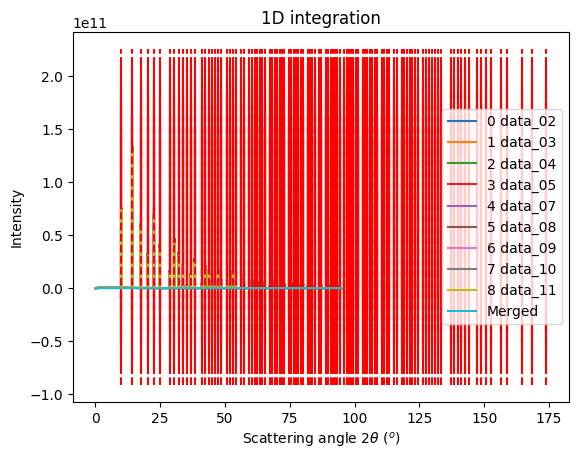

In [61]:
fig, ax = plt.subplots()
summed, counted, radial = None, None, None

for i in range(9):
    name = ds_names[i]
    ds = data[name]
    gonioref = goniometers[name]
    mg = gonioref.get_mg(position)
    mg.radial_range = (0, 95)
    images = [i.reshape(-1, 1) for i in ds]
    res_mg = mg.integrate1d(images, 50000)
    results[name] = res_mg    
    if summed is None:
        summed = res_mg.sum
        counted = res_mg.count
    else:
        summed += res_mg.sum
        counted += res_mg.count
    radial = res_mg.radial
    jupyter.plot1d(res_mg, label="%i %s"%(i, name), calibrant=LaB6, ax=ax )
    
ax.plot(radial, summed/counted, label="Merged")
ax.legend()
fig.show()    

## Multi-Gonio fit

Can we fit everything togeather ?
Just assume energy and scale parameter of the goniometer are the same for all modules and fit everything.

In [62]:
from scipy.optimize import minimize
class MultiGoniometer:
    def __init__(self, list_of_goniometers,
                param_name_split,
                param_name_common):
        self.nb_gonio = len(list_of_goniometers)
        self.goniometers = list_of_goniometers
        self.names_split = param_name_split
        self.names_common = param_name_common
        self.param = None
        
    def init_param(self):
        param = []
        for gonio in self.goniometers:
            param += list(gonio.param[:len(self.names_split)])
        param += list(gonio.param[len(self.names_split):])
        self.param = numpy.array(param)
    
    def residu2(self, param):
        "Actually performs the calulation of the average of the error squared"
        sumsquare = 0.0
        npt = 0
        for idx, gonio in enumerate(self.goniometers):
            gonio_param = numpy.concatenate((param[len(self.names_split)*idx:len(self.names_split)*(1+idx)],
                                             param[len(self.names_split)*len(self.goniometers):]))
            sumsquare += gonio.residu2(gonio_param)
        return sumsquare

    def chi2(self, param=None):
        """Calculate the average of the square of the error for a given parameter set
        """
        if param is not None:
            return self.residu2(param)
        else:
            if self.param is None:
                self.init_param()
            return self.residu2(self.param)
    def refine2(self, method="slsqp", **options):
        """Geometry refinement tool

        See https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.minimize.html

        :param method: name of the minimizer
        :param options: options for the minimizer
        """
        if method.lower() in ["simplex", "nelder-mead"]:
            method = "Nelder-Mead"

        former_error = self.chi2()
        print("Cost function before refinement: %s" % former_error)
        param = numpy.asarray(self.param, dtype=numpy.float64)
        print(param)
        res = minimize(self.residu2, param, method=method,
                       tol=1e-12,
                       options=options)
        print(res)
        newparam = res.x
        new_error = res.fun
        print("Cost function after refinement: %s" % new_error)

        if new_error < former_error:
            self.param = newparam
        return self.param
    
    def integrate(self, list_of_dataset, npt=50000, radial_range=(0,100)):
        summed = None
        counted = None
        param = self.param
        for idx, ds in enumerate(list_of_dataset):
            gonio = self.goniometers[idx]
            gonio_param = numpy.concatenate((param[len(self.names_split)*idx:len(self.names_split)*(1+idx)],
                                             param[len(self.names_split)*len(self.goniometers):]))
            print(gonio_param)
            gonio.param = gonio_param
            mg = gonio.get_mg(position)
            mg.radial_range = radial_range
            images = [i.reshape(-1, 1) for i in ds]
            res_mg = mg.integrate1d(images, 50000)
            if summed is None:
                summed = res_mg.sum
                counted = res_mg.count
            else:
                summed += res_mg.sum
                counted += res_mg.count
            radial = res_mg.radial
        res = Integrate1dResult(radial, summed/numpy.maximum(counted, 1e-10))
        res._set_unit(res_mg.unit)
        res._set_count(counted)
        res._set_sum(summed)
        return res

In [63]:
multigonio = MultiGoniometer([goniometers[ds_names[i]] for i in range(9)],
                 ["dist", "poni1", "poni2", "rot1", "offset"], 
                ["scale", "nrj"])


In [64]:
%time print(multigonio.chi2())
multigonio.param = numpy.array([ 7.20594053e-01,  3.22408604e-02,  4.05228023e-03, -2.75578440e-05,
       -8.27999414e+01,  7.20612302e-01,  3.36369797e-02,  4.02094516e-03,
       -1.74996556e-05, -7.71999791e+01,  7.20636130e-01,  3.47920978e-02,
        4.01341931e-03, -1.21330600e-05, -7.15999090e+01,  7.20757808e-01,
        3.33850817e-02,  3.95036100e-03,  3.46517345e-05, -6.57999267e+01,
        7.20813915e-01,  3.22167822e-02,  3.97128822e-03,  2.00055269e-05,
       -6.00000525e+01,  7.20881596e-01,  3.33801850e-02,  3.97760147e-03,
        1.47074593e-05, -5.43998157e+01,  7.21048510e-01,  3.22346939e-02,
        4.02104962e-03, -1.69519259e-05, -4.85998856e+01,  7.21074630e-01,
        3.08484557e-02,  4.09385968e-03, -6.91378973e-05, -4.27999030e+01,
        7.21154891e-01,  3.20619921e-02,  4.24950906e-03, -1.81328256e-04,
       -3.71999987e+01,  9.99038595e-01,  1.70266104e+01])
%time print(multigonio.chi2())


8.603024734828662e-09
CPU times: user 357 ms, sys: 15.9 ms, total: 373 ms
Wall time: 371 ms
6.139505955765795e-09
CPU times: user 308 ms, sys: 16 ms, total: 324 ms
Wall time: 323 ms


In [65]:
%time multigonio.refine2()

Cost function before refinement: 6.139505955765795e-09
[ 7.20594053e-01  3.22408604e-02  4.05228023e-03 -2.75578440e-05
 -8.27999414e+01  7.20612302e-01  3.36369797e-02  4.02094516e-03
 -1.74996556e-05 -7.71999791e+01  7.20636130e-01  3.47920978e-02
  4.01341931e-03 -1.21330600e-05 -7.15999090e+01  7.20757808e-01
  3.33850817e-02  3.95036100e-03  3.46517345e-05 -6.57999267e+01
  7.20813915e-01  3.22167822e-02  3.97128822e-03  2.00055269e-05
 -6.00000525e+01  7.20881596e-01  3.33801850e-02  3.97760147e-03
  1.47074593e-05 -5.43998157e+01  7.21048510e-01  3.22346939e-02
  4.02104962e-03 -1.69519259e-05 -4.85998856e+01  7.21074630e-01
  3.08484557e-02  4.09385968e-03 -6.91378973e-05 -4.27999030e+01
  7.21154891e-01  3.20619921e-02  4.24950906e-03 -1.81328256e-04
 -3.71999987e+01  9.99038595e-01  1.70266104e+01]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 6.139505955765795e-09
       x: [ 7.206e-01  3.224e-02 ...  9.990e-01  1.703e+01]
     nit: 1
  

array([ 7.20594053e-01,  3.22408604e-02,  4.05228023e-03, -2.75578440e-05,
       -8.27999414e+01,  7.20612302e-01,  3.36369797e-02,  4.02094516e-03,
       -1.74996556e-05, -7.71999791e+01,  7.20636130e-01,  3.47920978e-02,
        4.01341931e-03, -1.21330600e-05, -7.15999090e+01,  7.20757808e-01,
        3.33850817e-02,  3.95036100e-03,  3.46517345e-05, -6.57999267e+01,
        7.20813915e-01,  3.22167822e-02,  3.97128822e-03,  2.00055269e-05,
       -6.00000525e+01,  7.20881596e-01,  3.33801850e-02,  3.97760147e-03,
        1.47074593e-05, -5.43998157e+01,  7.21048510e-01,  3.22346939e-02,
        4.02104962e-03, -1.69519259e-05, -4.85998856e+01,  7.21074630e-01,
        3.08484557e-02,  4.09385968e-03, -6.91378973e-05, -4.27999030e+01,
        7.21154891e-01,  3.20619921e-02,  4.24950906e-03, -1.81328256e-04,
       -3.71999987e+01,  9.99038595e-01,  1.70266104e+01])

In [66]:
LaB6_new = get_calibrant("LaB6")
LaB6_new.wavelength = 1e-10*hc/multigonio.param[-1]
print(LaB6,"\n", LaB6_new)

LaB6 Calibrant with 109 reflections at wavelength 7.281789822635113e-11 
 LaB6 Calibrant with 109 reflections at wavelength 7.281789829007909e-11


In [67]:
%time res = multigonio.integrate([data[ds_names[i]] for i in range(9)])

[ 7.20594053e-01  3.22408604e-02  4.05228023e-03 -2.75578440e-05
 -8.27999414e+01  9.99038595e-01  1.70266104e+01]
[ 7.20612302e-01  3.36369797e-02  4.02094516e-03 -1.74996556e-05
 -7.71999791e+01  9.99038595e-01  1.70266104e+01]
[ 7.20636130e-01  3.47920978e-02  4.01341931e-03 -1.21330600e-05
 -7.15999090e+01  9.99038595e-01  1.70266104e+01]
[ 7.20757808e-01  3.33850817e-02  3.95036100e-03  3.46517345e-05
 -6.57999267e+01  9.99038595e-01  1.70266104e+01]
[ 7.20813915e-01  3.22167822e-02  3.97128822e-03  2.00055269e-05
 -6.00000525e+01  9.99038595e-01  1.70266104e+01]
[ 7.20881596e-01  3.33801850e-02  3.97760147e-03  1.47074593e-05
 -5.43998157e+01  9.99038595e-01  1.70266104e+01]
[ 7.21048510e-01  3.22346939e-02  4.02104962e-03 -1.69519259e-05
 -4.85998856e+01  9.99038595e-01  1.70266104e+01]
[ 7.21074630e-01  3.08484557e-02  4.09385968e-03 -6.91378973e-05
 -4.27999030e+01  9.99038595e-01  1.70266104e+01]
[ 7.21154891e-01  3.20619921e-02  4.24950906e-03 -1.81328256e-04
 -3.71999987e+0

/tmp/ipykernel_367778/1083240546.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ax.figure.show()


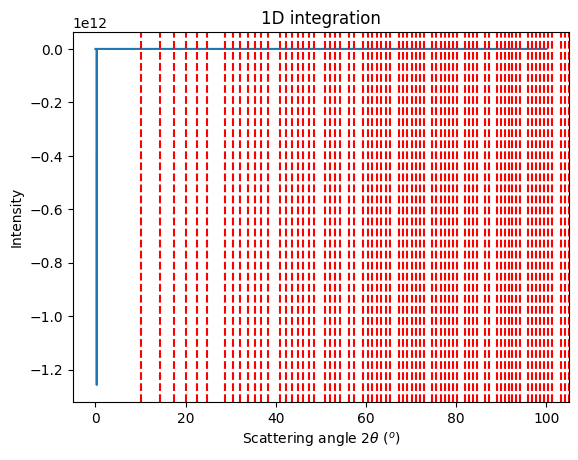

In [68]:
ax = jupyter.plot1d(res, calibrant=LaB6_new)
ax.figure.show()

28454
68 60


/tmp/ipykernel_367778/344732789.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


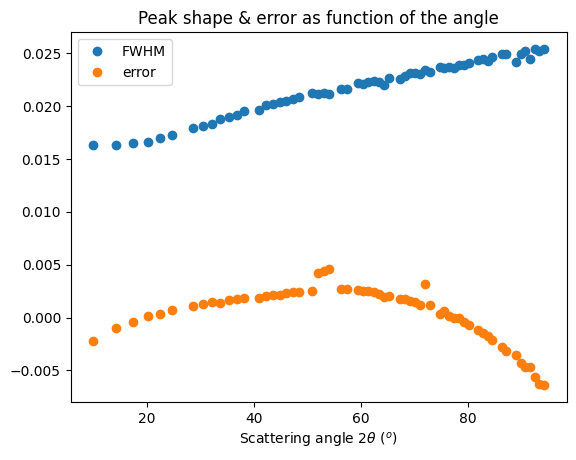

In [69]:
fig, ax = plt.subplots()
ax.plot(*calc_fwhm(res, LaB6_new, 10, 95), "o", label="FWHM")
ax.plot(*calc_peak_error(res, LaB6_new, 10, 95), "o", label="error")
ax.set_title("Peak shape & error as function of the angle")
ax.set_xlabel(res.unit.label)
ax.legend()
fig.show()

In [70]:
print("total run time: ", time.time()-start_time)

total run time:  1055.6983478069305


## Conclusion
The calibration works and the FWHM of every single peak is pretty small: 0.02°. 
The geometry has been refined with the wavelength: 
The goniometer scale parameter refines to 0.999 instead of 1 and the wavelength is fitted with a change at the 5th digit which is pretty precise.